# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
from scipy.stats import zscore


# Set style for plots
plt.style.use('seaborn')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [ ]:
def load_signal_unfiltered(file_path, signal_name):
    """
    Load a signal file using numeric Unix timestamps (float seconds).
    Keeps all timestamps — no filtering.
    """
    df = pd.read_csv(file_path, header=None)
    if df.shape[0] < 3:
        return None

    start_time = float(df.iloc[0, 0])
    sample_rate = float(df.iloc[1, 0])
    data = df.iloc[2:].reset_index(drop=True).astype(float)

    # Compute Unix timestamps without filtering
    timestamps = start_time + (data.index / sample_rate)
    data.columns = [signal_name]
    data['timestamp'] = timestamps

    return data

def load_data(data_dir='data'):
    root_dir = Path(data_dir)
    all_data = []

    for participant_folder in root_dir.iterdir():
        if not participant_folder.is_dir():
            continue

        for session_folder in participant_folder.iterdir():
            if not session_folder.is_dir():
                continue

            subject_id = participant_folder.name
            session = session_folder.name

            # File paths
            hr_path = session_folder / 'HR.csv'
            eda_path = session_folder / 'EDA.csv'
            temp_path = session_folder / 'TEMP.csv'

            # Load signals
            hr_df = load_signal_unfiltered(hr_path, 'heart_rate') if hr_path.exists() else None
            eda_df = load_signal_unfiltered(eda_path, 'eda') if eda_path.exists() else None
            temp_df = load_signal_unfiltered(temp_path, 'temperature') if temp_path.exists() else None

            # Outer merge on timestamps
            merged = None
            for df in [hr_df, eda_df, temp_df]:
                if df is not None:
                    if merged is None:
                        merged = df
                    else:
                        merged = pd.merge(merged, df, on='timestamp', how='outer')

            if merged is None:
                continue

            merged['subject_id'] = subject_id
            merged['session'] = session

            all_data.append(merged)

    if not all_data:
        return pd.DataFrame(columns=['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session'])

    full_df = pd.concat(all_data, ignore_index=True)
    return full_df[['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']]



,timestamp,heart_rate,eda,temperature,subject_id,session
0,1.541859e+09,NaN,0.000000,22.17,S5,Midterm 2
1,1.541859e+09,NaN,0.002562,22.17,S5,Midterm 2
2,1.541859e+09,NaN,0.021776,22.17,S5,Midterm 2
3,1.541859e+09,NaN,0.021776,22.17,S5,Midterm 2
4,1.541859e+09,NaN,0.019214,22.17,S5,Midterm 2
...,...,...,...,...,...,...
1773140,1.544042e+09,NaN,0.011532,23.21,S9,Final
1773141,1.544042e+09,NaN,0.012813,23.21,S9,Final
1773142,1.544042e+09,NaN,0.011532,23.21,S9,Final
1773143,1.544042e+09,123.07,0.011532,NaN,S9,Final


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [ ]:
full_df = load_data('data')
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    processed_subjects = []

    # Process per subject
    for subject_id, subject_df in data.groupby('subject_id'):
        subject_df = subject_df.sort_values('timestamp')

        #Handle missing values — only if <= 1% missing per column
        allowed_missing = int(0.01 * len(subject_df))
        for col in ['heart_rate', 'eda', 'temperature']:
            missing = subject_df[col].isna().sum()
            if missing <= allowed_missing:
                subject_df[col] = subject_df[col].fillna(subject_df[col].mean())
            else:
                # If more than 1% missing, skip column
                continue

        # Resample to 1-second interval (convert timestamp to datetime first)
        subject_df['timestamp'] = pd.to_datetime(subject_df['timestamp'], unit='s')
        resampled = []
        
        for session, session_df in subject_df.groupby('session'):
            session_df = session_df.set_index('timestamp').sort_index()
            numeric_cols = ['heart_rate', 'eda', 'temperature']
            session_resampled = session_df[numeric_cols].resample('1s').mean()
            session_resampled['session'] = session
            resampled.append(session_resampled)
        
        subject_df = pd.concat(resampled).reset_index()
        subject_df['subject_id'] = subject_id

        # Remove outliers using z-score threshold > 3.5
        for col in ['heart_rate', 'eda', 'temperature']:
            if col in subject_df.columns:
                z = zscore(subject_df[col], nan_policy='omit')
                subject_df.loc[np.abs(z) > 3.5, col] = np.nan

        # Re-impute with column mean after outlier removal
        for col in ['heart_rate', 'eda', 'temperature']:
            if col in subject_df.columns:
                subject_df[col] = subject_df[col].fillna(subject_df[col].mean())

        # Save to file
        base_path = os.path.join(output_dir, f"{subject_id}_processed")
        if output_dir.endswith(".parquet"):
            subject_df.to_parquet(base_path + ".parquet", index=False)
        elif output_dir.endswith(".feather"):
            subject_df.to_feather(base_path + ".feather")
        else:
            subject_df.to_csv(base_path + ".csv", index=False)

        processed_subjects.append(subject_df)

    # Combine and return full preprocessed DataFrame
    final_df = pd.concat(processed_subjects, ignore_index=True)
    return final_df[['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']]

preprocess_data(full_df, 'data/processed')

,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-12-05 16:28:57,106.127744,0.011852,21.890000,S1,Final
1,2018-12-05 16:28:58,106.127744,0.023064,21.890000,S1,Final
2,2018-12-05 16:28:59,106.127744,0.023704,21.910000,S1,Final
3,2018-12-05 16:29:00,106.127744,0.023384,21.910000,S1,Final
4,2018-12-05 16:29:01,106.127744,0.023704,21.890000,S1,Final
...,...,...,...,...,...,...
443297,2018-11-10 17:44:42,159.470000,0.015055,22.970000,S9,Midterm 2
443298,2018-11-10 17:44:43,158.680000,0.014735,22.970000,S9,Midterm 2
443299,2018-11-10 17:44:44,157.720000,0.014735,22.970000,S9,Midterm 2
443300,2018-11-10 17:44:45,156.450000,0.014735,28.443362,S9,Midterm 2


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

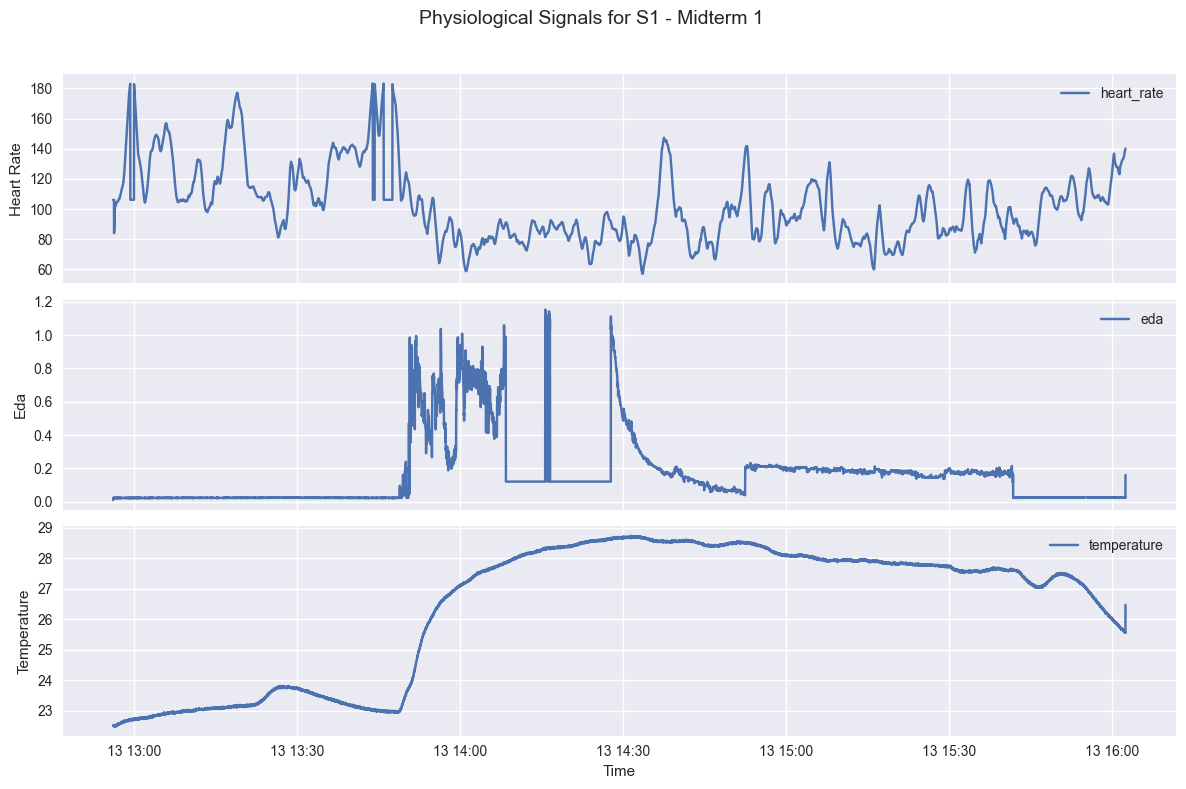

In [65]:
full_df = load_data('data')
processed_data = preprocess_data(full_df, 'data/processed')

def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Filter data for the subject and session
    df = data[(data['subject_id'] == subject_id) & (data['session'] == session)]
    if df.empty:
        raise ValueError(f"No data found for subject {subject_id}, session {session}")

    # Create figure with 3 subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"Physiological Signals for {subject_id} - {session}", fontsize=14)

    # Plot signals
    signals = ['heart_rate', 'eda', 'temperature']
    for ax, signal in zip(axes, signals):
        ax.plot(df['timestamp'], df[signal], label=signal)
        ax.set_ylabel(signal.replace('_', ' ').title())
        ax.grid(True)
        ax.legend(loc='upper right')

    axes[-1].set_xlabel("Time")

    # Save plot to file
    safe_session = session.replace(" ", "_")
    filename = f"{subject_id}_{safe_session}_signals.png"
    filepath = os.path.join(output_dir, filename)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(filepath)
    plt.close(fig)

    return fig
 
plot_physiological_signals(processed_data, 'S1','Midterm 1', 'plots')